In [ ]:

#!pip install matplotlib==3.5.2 pydicom==2.3.0 highdicom==0.22.0 numpy==1.26.4


1. Save the file to the root folder instead of the gcs folder where it is by default
2. Run this on the top of the notebook: !pip install matplotlib==3.5.2 pydicom==2.3.0 highdicom==0.22.0 numpy==1.26.4
3. Comment it out after #!pip install matplotlib==3.5.2 pydicom==2.3.0 highdicom==0.22.0 numpy==1.26.4
4. Then restart the kernel

# Loading cspine data

This notebook provides example code for loading the CSpine data from the multiframe DICOM files and associated masks from the segmentation DICOM files.

In [ ]:
from pathlib import Path
from collections import OrderedDict

import pydicom
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
from imageio.v3 import imread
import highdicom as hd

## Helper function: DICOM to numpy

This function loads the DICOM image pixels into a numpy array. As these are multiframe DICOMs, the pixels contain the entire volume. The array dimensions are: (slices x H x W). As they are axial CTs, slices are by default axial.

In [ ]:
def dicom2image(plan, width=None, level=None, norm=True):
    """
    Load windowed pixels from a DICOM Dataset

    See also: https://www.kaggle.com/code/wfwiggins203/eda-dicom-tags-windowing-head-cts/notebook
    """

    pixels = plan.pixel_array * plan.RescaleSlope + plan.RescaleIntercept

    if not width:
        width = plan.WindowWidth
        if not isinstance(width, pydicom.valuerep.DSfloat):
            width = width[0]
    if not level:
        level = plan.WindowCenter
        if not isinstance(level, pydicom.valuerep.DSfloat):
            level = level[0]

    lower = level - (width / 2)
    upper = level + (width / 2)
    img = np.clip(pixels, lower, upper)

    if norm:
        return (img - lower) / (upper - lower)
    else:
        return img

def segmentation2labels(segmentation, plan):
    """Returns an array of integer labels indicating segmentation locations.

    Inputs
        segmentation - a highdicom Segmentation object
        plan - a pydicom Dataset (the source multi-frame CT)

    Returns
        numpy array with 4th axis spanning different labels 0/1 encoded

    Only the NumberOfFrames attribute is used from plan.
    """
    sop_uid = segmentation.get_source_image_uids()[0][2]
    pixels = segmentation.get_pixels_by_source_frame(
        source_sop_instance_uid=sop_uid,
        # get a mask for all frames in the original dicom
        # i.e. get a mask for all slices of the CT
        source_frame_numbers=[x+1 for x in range(plan.NumberOfFrames)],
        # if a mask is not present for a frame, highdicom will raise an error,
        # as the segmentation plan contains no data for frames with no segmentations
        # setting this bool to true tells highdicom to assume the frames we request
        # exist, and assume that they are all 0s (i.e. no segmentation)
        assert_missing_frames_are_empty=True
    )
    return pixels

mask_map = OrderedDict([
    ['No segmentation', [0, 0, 0]],
    ['Acute C1', [255,0,0]],
    ['Acute C2', [255,127,0]],
    ['Acute C3', [255,212,0]],
    ['Acute C4', [237,185,185]],
    ['Acute C5', [143,35,35]],
    ['Acute C6', [143,106,35]],
    ['Acute C7', [79,143,35]],
    ['Chronic C1', [35,98,143]],
    ['Chronic C2', [107,35,143]],
    ['Chronic C3', [106,255,0]],
    ['Chronic C4', [0,234,255]],
    ['Chronic C5', [231,233,185]],
    ['Chronic C6', [185,215,237]],
    ['Chronic C7', [115,115,115]]
])

mask_labels = {i: k for i, k in enumerate(mask_map.keys())}
mask_rgb = {i: rgb for i, rgb in enumerate(mask_map.values())}

def mask2rgb(mask, slice_number, mask_map=mask_map):
    """Given an integer mask and slice, extract an RGB mask"""
    mask_slice = np.zeros([mask.shape[1], mask.shape[2], 3], dtype=np.uint8)

    # convert the 14 integers into rgb values
    for m, (label, rgb_value) in enumerate(mask_map.items()):
        if m == 0:
            continue

        # for slice s, see if there is a boolean True value for this segmentation
        # we use m-1 as the mask_map has 0 == No Segmentation, and this label is not
        # in the mask array
        idx = mask[slice_number, :, :, m-1] == 1
        if idx.any():
            # if there is, we have a positive segmentation here
            mask_slice[idx, :] = rgb_value

    return mask_slice

In [ ]:
base_path = Path('gcs').resolve()
dicom_path = base_path / 'dicom'
segmentation_path = base_path / 'segmentation'

study_id = '693827-007466_7756'

## Load a single study

In [ ]:
plan = pydicom.dcmread(dicom_path / f'{study_id}.dcm')
volume = dicom2image(plan)
volume.shape

In [ ]:
# Axial
plt.figure(figsize=(8, 8))
plt.imshow(volume[194, :, :], cmap=plt.cm.bone)

# Plot lines for sagittal and coronal planes
# plt.vlines(300, 0, 512, colors='g')
# plt.hlines(300, 0, 512, colors='b');

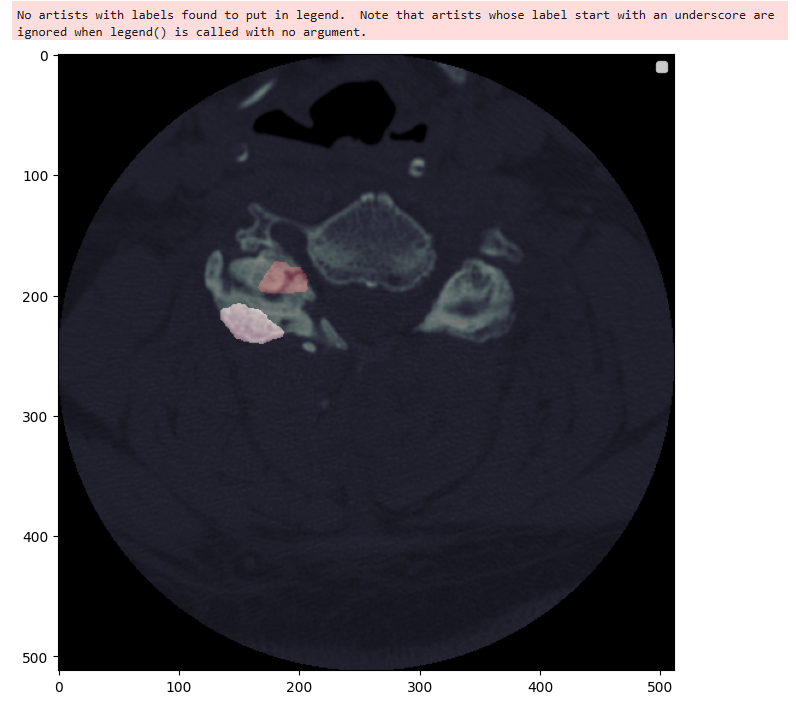

## Load a study with the segmentation mask

In [ ]:
plan = pydicom.dcmread(dicom_path / f'{study_id}.dcm')
segmentation = pydicom.dcmread(segmentation_path / f'{study_id}.dcm')
# convert to segmentation class
segmentation = hd.seg.Segmentation.from_dataset(segmentation)

# labels is a (N_FRAMES, Rows, Columns, N_LABELS) numpy array of 1s and 0s
# it one-hot encodes the segmentations
labels = segmentation2labels(segmentation, plan)

# extract a mask for a single slice, and map it to fixed RGB values
slice_number = 196
mask = mask2rgb(labels, slice_number=slice_number, mask_map=mask_map)

# plot the image with the mask overlaid
plt.figure(figsize=(8, 8))
plt.imshow(volume[slice_number, :, :], cmap=plt.cm.bone)
plt.imshow(mask, alpha=0.5)
plt.legend()
plt.show()

## Load all images with masks

Each study requires ~200 MB of memory. Loading all studies will require at least 200 GB of memory.

In [ ]:
base_path = Path('gcs').resolve()
dicom_path = base_path / 'dicom'
segmentation_path = base_path / 'segmentation'

study_ids = os.listdir(dicom_path)
# remove .dcm extension from study IDs
study_ids = [s.split('.')[0] for s in study_ids]
#study_ids = study_ids[:1]

volumes = []
masks = []
for study_id in tqdm(study_ids, desc='Loading DICOM studies', total=len(study_ids)):
    if study_id == '693827-007466_7756':
        patient_id = study_id.split('_')[0]

        plan = pydicom.dcmread(dicom_path / f'{study_id}.dcm')

        volume = dicom2image(plan)
        volumes.append(volume)

        segmentation_filename = segmentation_path / f'{study_id}.dcm'

        if segmentation_filename.exists():
            segmentation = pydicom.dcmread(segmentation_filename)
            segmentation = hd.seg.Segmentation.from_dataset(segmentation)
            #label = segmentation2mask(segmentation)
            # labels is a (N_FRAMES, Rows, Columns, N_LABELS) numpy array of 1s and 0s
            # it one-hot encodes the segmentations
            labels = segmentation2labels(segmentation, plan)

            # Create a list to store masks for all slices
            all_slice_masks = []

            # Get number of slices from the labels shape
            n_slices = labels.shape[0]

            # Generate mask for each slice
            for slice_number in range(n_slices):
                slice_mask = mask2rgb(labels, slice_number=slice_number, mask_map=mask_map)
                all_slice_masks.append(slice_mask)

            # Convert list of masks to numpy array if needed
            label = np.array(all_slice_masks)


            del segmentation
        else:
            label = None

        masks.append(label)

        del plan

In [ ]:

# Define the number of slices to display per figure
slices_per_figure = 10

# Display all slices and segmentations for each study ID
for i, (volume, mask) in enumerate(zip(volumes, masks)):
    num_slices = volume.shape[0]  # Assuming the volume is in the shape (slices, height, width)

    for start in range(0, num_slices, slices_per_figure):
        end = min(start + slices_per_figure, num_slices)
        fig, axes = plt.subplots(end - start, 2, figsize=(10, (end - start) * 3))
        fig.suptitle(f'Study ID: {study_ids[i]} (Slices {start + 1} to {end})', fontsize=16)

        for j, slice_idx in enumerate(range(start, end)):
            # Plot the volume slice
            axes[j, 0].imshow(volume[slice_idx], cmap='gray')
            axes[j, 0].axis('off')
            axes[j, 0].set_title(f'Slice {slice_idx + 1}')

            # Plot the segmentation mask slice, if it exists
            if mask is not None:
                mask_slice = mask[slice_idx] if len(mask.shape) > 2 else mask  # Handle different mask shapes
                overlay = np.ma.masked_where(mask_slice == 0, mask_slice)  # Mask zeros for overlay

                axes[j, 1].imshow(volume[slice_idx], cmap='gray')
                axes[j, 1].imshow(overlay, cmap='jet', alpha=0.5)  # Overlay segmentation in color
                axes[j, 1].axis('off')
                axes[j, 1].set_title(f'Segmentation Slice {slice_idx + 1}')
            else:
                axes[j, 1].axis('off')
                axes[j, 1].set_title('No Segmentation')

        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()

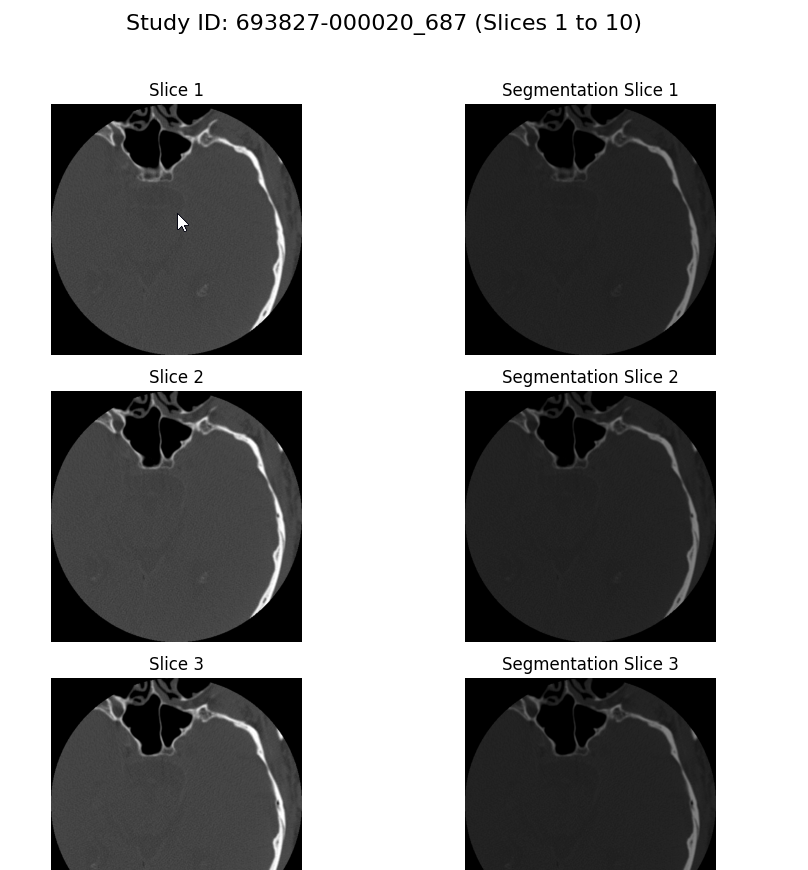